In [1]:
# http://tomaugspurger.github.io/modern-5-tidy.html
# pip install lxml bs4 seaborn

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.options.display.max_rows = 10
sns.set(style='ticks', context='talk')

In [3]:
tables = pd.read_html("http://www.basketball-reference.com/leagues/NBA_2016_games.html")
games = tables[0]
print len(games.index)
games.head()

38


,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,,.1,Notes
0,"Tue, Oct 27, 2015",8:00 pm,Detroit Pistons,106,Atlanta Hawks,94,Box Score,NaN,NaN
1,"Tue, Oct 27, 2015",8:00 pm,Cleveland Cavaliers,95,Chicago Bulls,97,Box Score,NaN,NaN
2,"Tue, Oct 27, 2015",10:30 pm,New Orleans Pelicans,95,Golden State Warriors,111,Box Score,NaN,NaN
3,"Wed, Oct 28, 2015",7:30 pm,Philadelphia 76ers,95,Boston Celtics,112,Box Score,NaN,NaN
4,"Wed, Oct 28, 2015",7:30 pm,Chicago Bulls,115,Brooklyn Nets,100,Box Score,NaN,NaN


In [4]:
column_names = {'Date': 'date', 'Start (ET)': 'start',
                'Unamed: 2': 'box', 'Visitor/Neutral': 'away_team', 
                'PTS': 'away_points', 'Home/Neutral': 'home_team',
                'PTS.1': 'home_points', 'Unamed: 7': 'n_ot'}

games = games.rename(columns=column_names)
games = games.dropna(thresh=4)
games = games[['date', 'away_team', 'away_points', 'home_team', 'home_points']]
games = games.assign(date=lambda x: pd.to_datetime(x['date'], format='%a, %b %d, %Y'))
games = games.set_index('date', append=True)
games = games.rename_axis(["game_id", "date"])
games = games.sort_index()
print len(games.index)
games.head()

38


,,away_team,away_points,home_team,home_points
game_id,date,,,,
0,2015-10-27,Detroit Pistons,106,Atlanta Hawks,94
1,2015-10-27,Cleveland Cavaliers,95,Chicago Bulls,97
2,2015-10-27,New Orleans Pelicans,95,Golden State Warriors,111
3,2015-10-28,Philadelphia 76ers,95,Boston Celtics,112
4,2015-10-28,Chicago Bulls,115,Brooklyn Nets,100


In [5]:
tidy = pd.melt(games.reset_index(),
               id_vars=['game_id', 'date'], value_vars=['away_team', 'home_team'],
               value_name='team')
print len(tidy.index)
tidy.head()

76


,game_id,date,variable,team
0,0,2015-10-27,away_team,Detroit Pistons
1,1,2015-10-27,away_team,Cleveland Cavaliers
2,2,2015-10-27,away_team,New Orleans Pelicans
3,3,2015-10-28,away_team,Philadelphia 76ers
4,4,2015-10-28,away_team,Chicago Bulls


In [6]:
tidy.groupby('team')['date'].diff().dt.days - 1

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
     ... 
71    1.0
72    2.0
73    2.0
74    2.0
75    0.0
Name: date, Length: 76, dtype: float64

In [7]:
tidy['rest'] = tidy.sort_values('date').groupby('team').date.diff().dt.days - 1
print len(tidy.index)
tidy.dropna().head()

76


,game_id,date,variable,team,rest
4,4,2015-10-28,away_team,Chicago Bulls,0.0
8,8,2015-10-28,away_team,Cleveland Cavaliers,0.0
14,14,2015-10-28,away_team,New Orleans Pelicans,0.0
17,17,2015-10-29,away_team,Memphis Grizzlies,0.0
18,18,2015-10-29,away_team,Dallas Mavericks,0.0


In [8]:
by_game = pd.pivot_table(tidy, values='rest', 
                         index=['game_id', 'date'],
                         columns='variable')
by_game = by_game.rename(columns={'away_team': 'away_rest',
                                  'home_team': 'home_rest'})
df = pd.concat([games, by_game], axis=1)
df.dropna().head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest
game_id,date,,,,,,
17,2015-10-29,Memphis Grizzlies,112,Indiana Pacers,103,0.0,0.0
18,2015-10-29,Dallas Mavericks,88,Los Angeles Clippers,104,0.0,0.0
19,2015-10-29,Atlanta Hawks,112,New York Knicks,101,1.0,0.0
20,2015-10-30,Charlotte Hornets,94,Atlanta Hawks,97,1.0,0.0
21,2015-10-30,Toronto Raptors,113,Boston Celtics,103,1.0,1.0


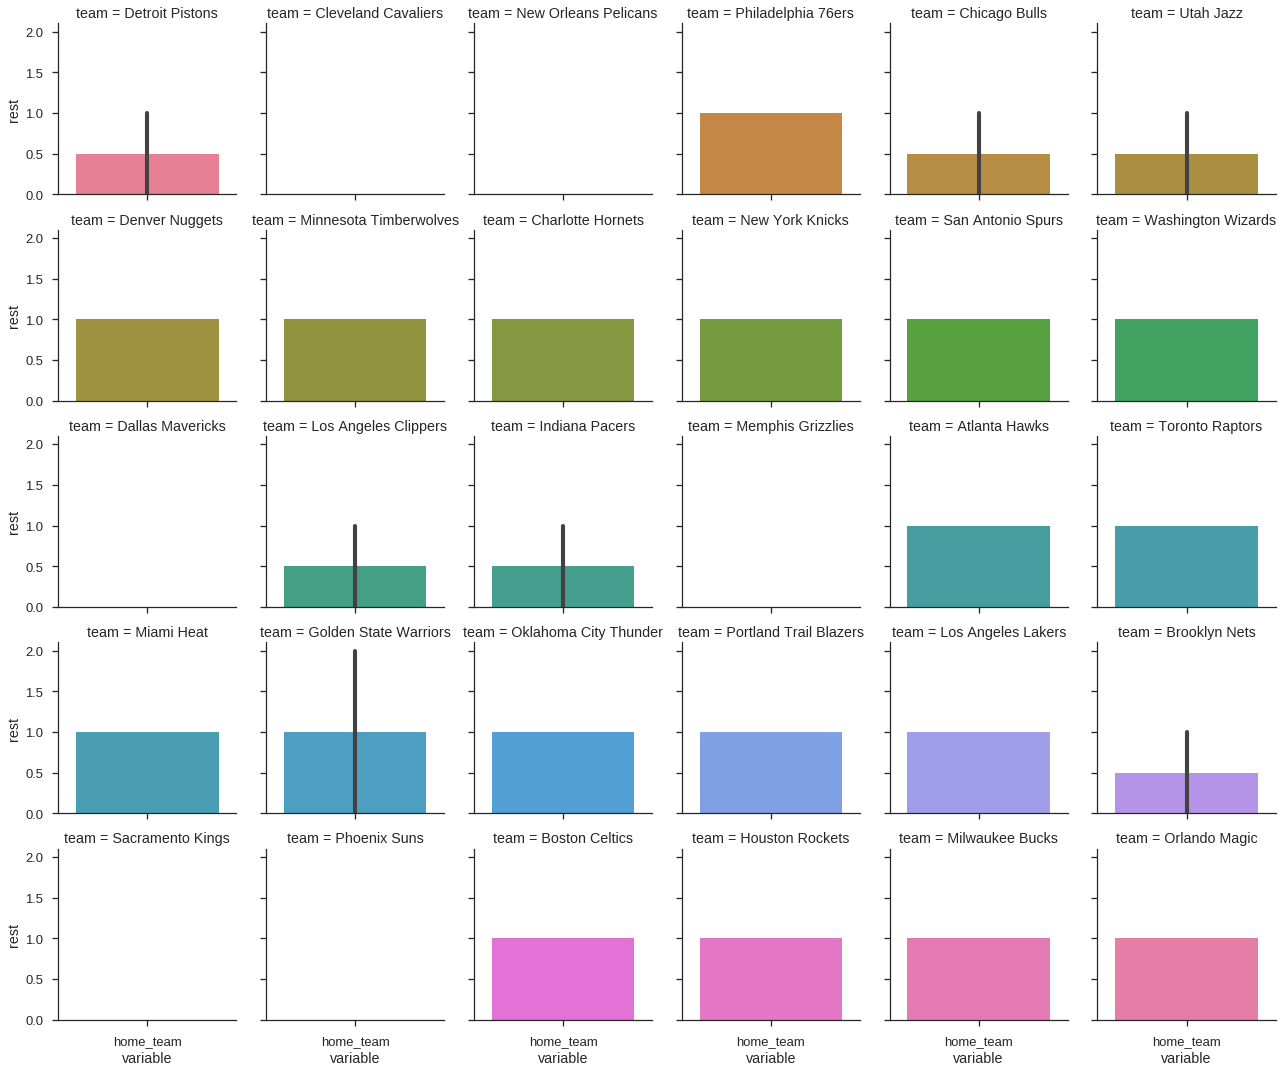

In [9]:
%matplotlib inline
g = sns.FacetGrid(tidy, col='team', col_wrap=6, hue='team')
g.map(sns.barplot, 'variable', 'rest');

In [10]:
df['home_win'] = df['home_points'] > df['away_points']
df['rest_spread'] = df['home_rest'] - df['away_rest']
df.dropna().head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest,home_win,rest_spread
game_id,date,,,,,,,,
17,2015-10-29,Memphis Grizzlies,112,Indiana Pacers,103,0.0,0.0,False,0.0
18,2015-10-29,Dallas Mavericks,88,Los Angeles Clippers,104,0.0,0.0,True,0.0
19,2015-10-29,Atlanta Hawks,112,New York Knicks,101,1.0,0.0,False,-1.0
20,2015-10-30,Charlotte Hornets,94,Atlanta Hawks,97,1.0,0.0,True,-1.0
21,2015-10-30,Toronto Raptors,113,Boston Celtics,103,1.0,1.0,False,0.0


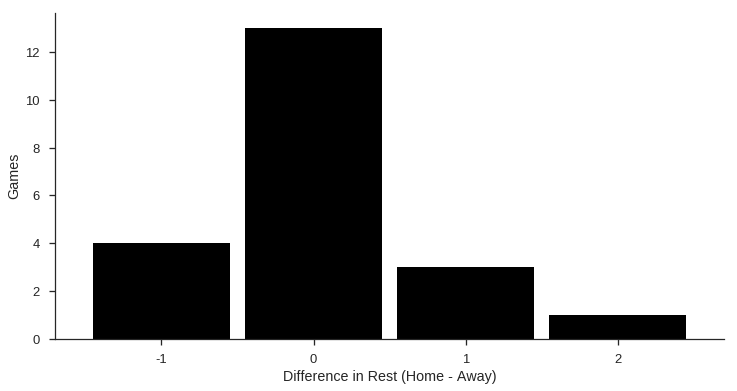

In [11]:
delta = (by_game.home_rest - by_game.away_rest).dropna().astype(int)
ax = (delta.value_counts()
    .reindex(np.arange(delta.min(), delta.max() + 1), fill_value=0)
    .sort_index()
    .plot(kind='bar', color='k', width=.9, rot=0, figsize=(12, 6))
)
sns.despine()
ax.set(xlabel='Difference in Rest (Home - Away)', ylabel='Games');

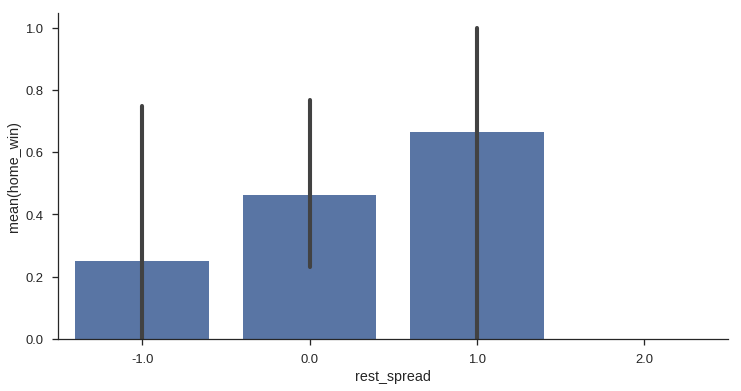

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='rest_spread', y='home_win', data=df.query('-3 <= rest_spread <= 3'),
            color='#4c72b0', ax=ax)
sns.despine()